In [1]:
%cd /Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model

from utils.post_training import *
from utils.statistics import *
from utils.plotting import *
from utils.angle_encoding_script import angle_encoding
from utils.haar_noising_script import apply_haar_scrambling
from utils.statistics import calculate_statistics, calculate_fid
from utils.decoding import decode, flip

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg

import pennylane as qml

/Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model


In [5]:
QG_channel = 1
filename = f"data/QG{QG_channel}_64x64_1k"
data_X = np.array(h5py.File(filename, "r")['X'])
print(data_X.shape)

num_samples = 1000

encoded_data = torch.load("data/QG1_64x64_1000_encoded.pt")
scrambled_states = torch.load("data/QG1_64x64_1000_scrambled.pt")

(1000, 64, 64)


In [ ]:
# ONLY RERUN TO REENCODE OR RESCRAMBLE DATA
encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = torch.tensor(np.array(encoded_data), dtype=torch.float32)
print(encoded_data.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)

torch.save(encoded_data, f"data/QG{QG_channel}_64x64_{num_samples}_encoded.pt")
torch.save(scrambled_states, f"data/QG{QG_channel}_64x64_{num_samples}_scrambled.pt")

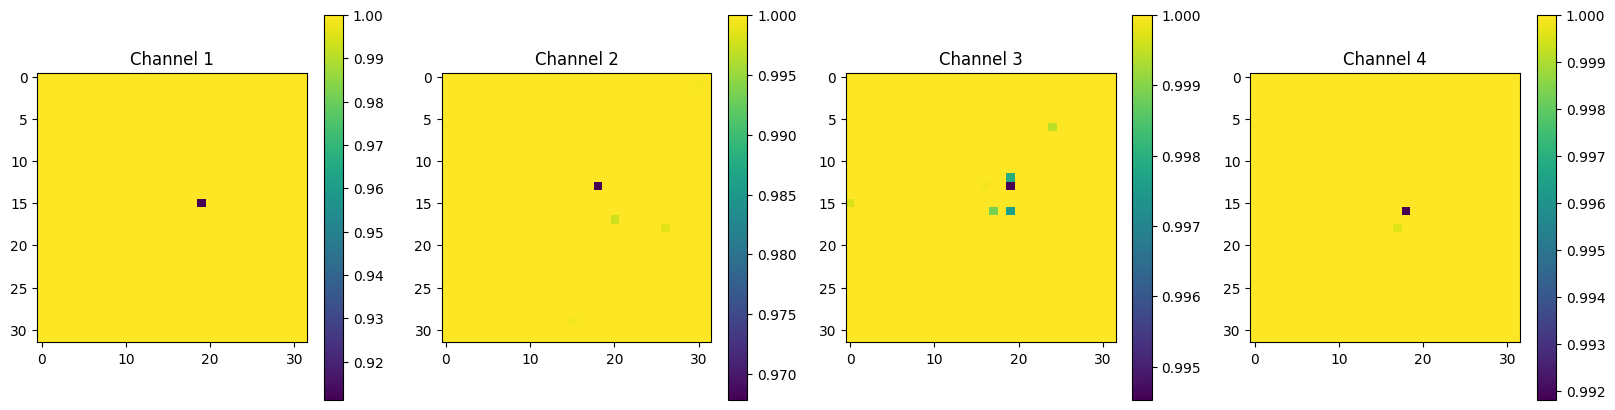

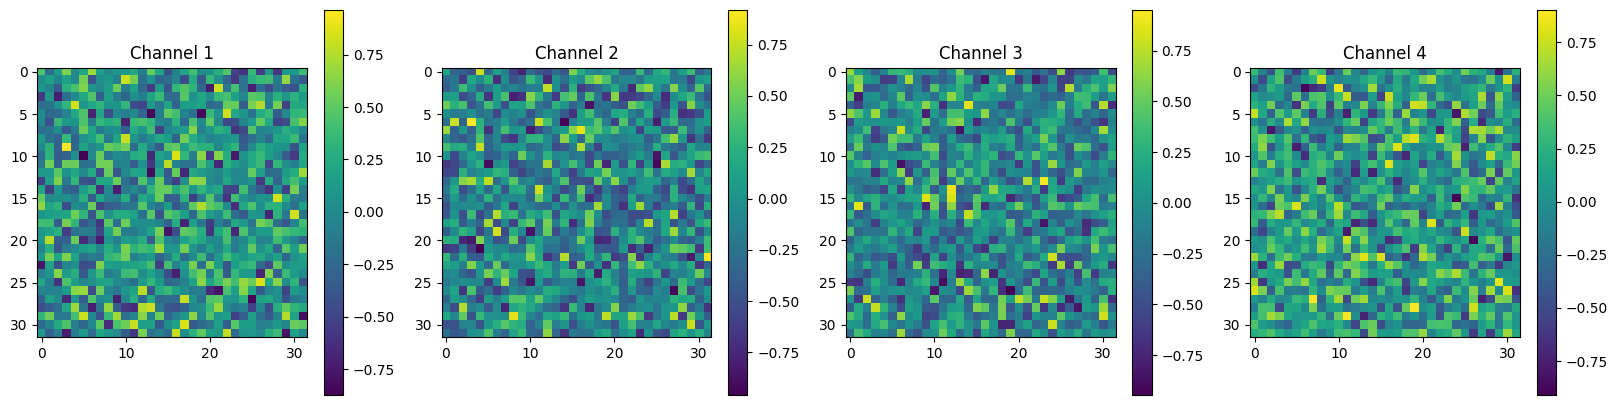

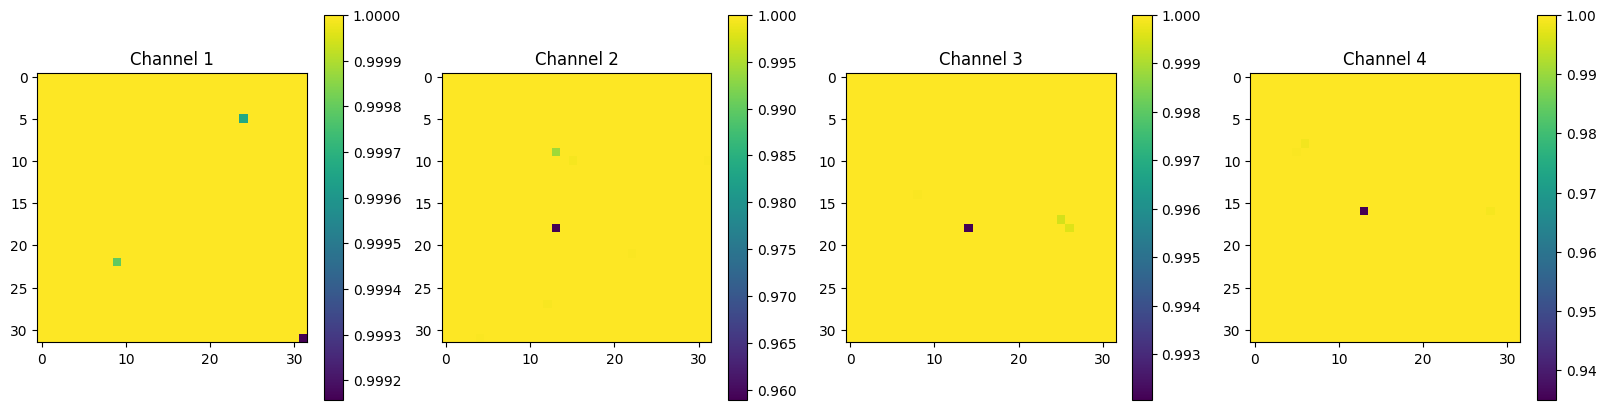

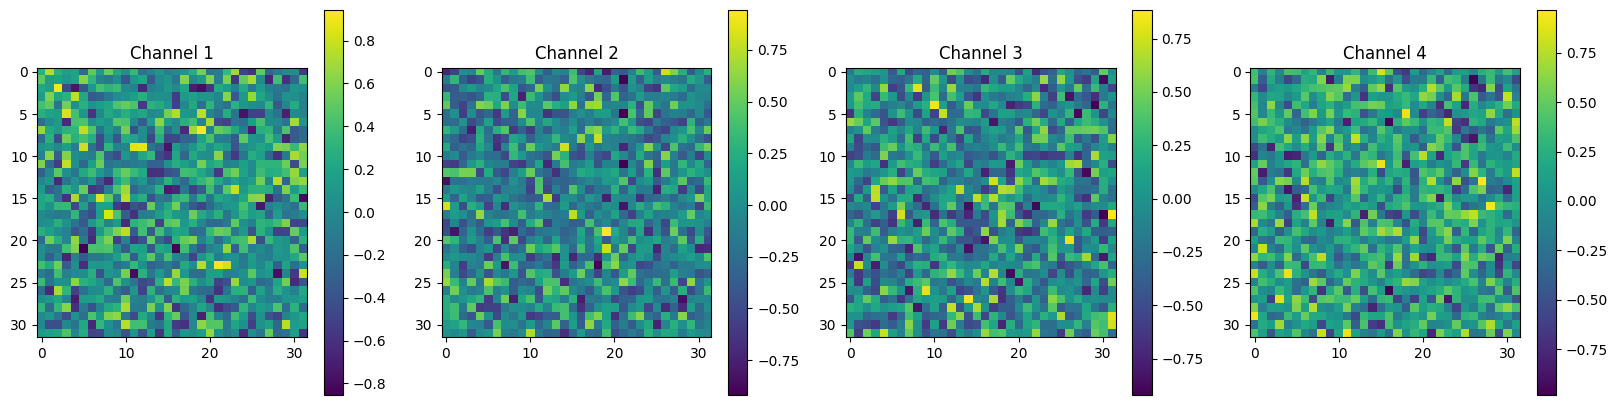

In [6]:
def visualize_encoded_data(encoded_data, sample_index=0):
    encoded_sample = encoded_data[sample_index]

    fig, axes = plt.subplots(1, 4, figsize=(20, 5)) 
    for channel in range(4):
        ax = axes[channel]
        encoded_image = encoded_sample[:, :, channel]
        im = ax.imshow(encoded_image, cmap='viridis')
        fig.colorbar(im, ax=ax)
        ax.set_title(f'Channel {channel+1}')
    plt.show()

visualize_encoded_data(encoded_data, sample_index=0)
visualize_encoded_data(scrambled_states, sample_index=0)
visualize_encoded_data(encoded_data, sample_index=1)
visualize_encoded_data(scrambled_states, sample_index=1)

In [28]:
train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data[:num_samples], scrambled_states, test_size=0.2, random_state=42, shuffle=True
)

n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QuantumLayer, self).__init__()
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

class QuantumDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(QuantumDiffusionModel, self).__init__()
        self.n_qubits = n_qubits
        self.num_patches = input_dim // n_qubits
        
        self.quantum_layer = QuantumLayer(n_qubits, n_layers)
        
    def forward(self, x):
        x_patched = x.view(-1, self.num_patches, self.n_qubits)  # [batch_size, num_patches, n_qubits]

        output_patches = []
        for patch in range(self.num_patches):
            patch_out = self.quantum_layer(x_patched[:, patch])
            output_patches.append(patch_out)
        
        x = torch.cat(output_patches, dim=1)
        
        return x

In [29]:
n_layers = 8
input_dim = 32 * 32 * 4
hidden_dim = 128
output_dim = input_dim  
dim = 32

model = QuantumDiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 50
loss_values = []
val_loss_values = []

# Decode for 64 dim
def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()  
    with torch.no_grad():
        random_noise = torch.randn(num_images, input_dim)
        generated_data = model(random_noise)
        generated_data = flip(generated_data.view(num_images, dim, dim, 4).detach().numpy())
        decoded_images = decode(generated_data) 

    return decoded_images

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states.view(len(train_scrambled_states), -1))
    loss = criterion(outputs, train_encoded_data.view(len(train_encoded_data), -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        val_loss = criterion(val_outputs, val_encoded_data.view(len(val_encoded_data), -1))
        val_loss_values.append(val_loss.item())
        
        denoised_states = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        denoised_states = denoised_states.view(len(val_scrambled_states), 32, 32, 4).detach().numpy()
        decoded_data = decode(denoised_states)
        decoded_data = flip(decoded_data)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

plt.figure(figsize=(10, 5))

plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1638400 bytes.

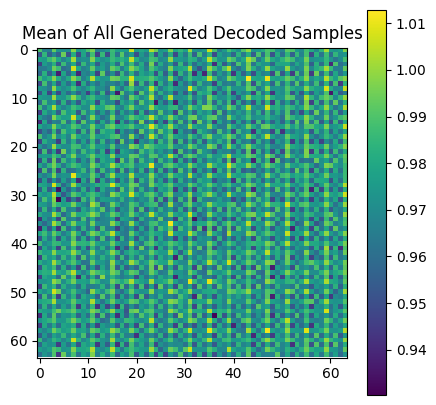

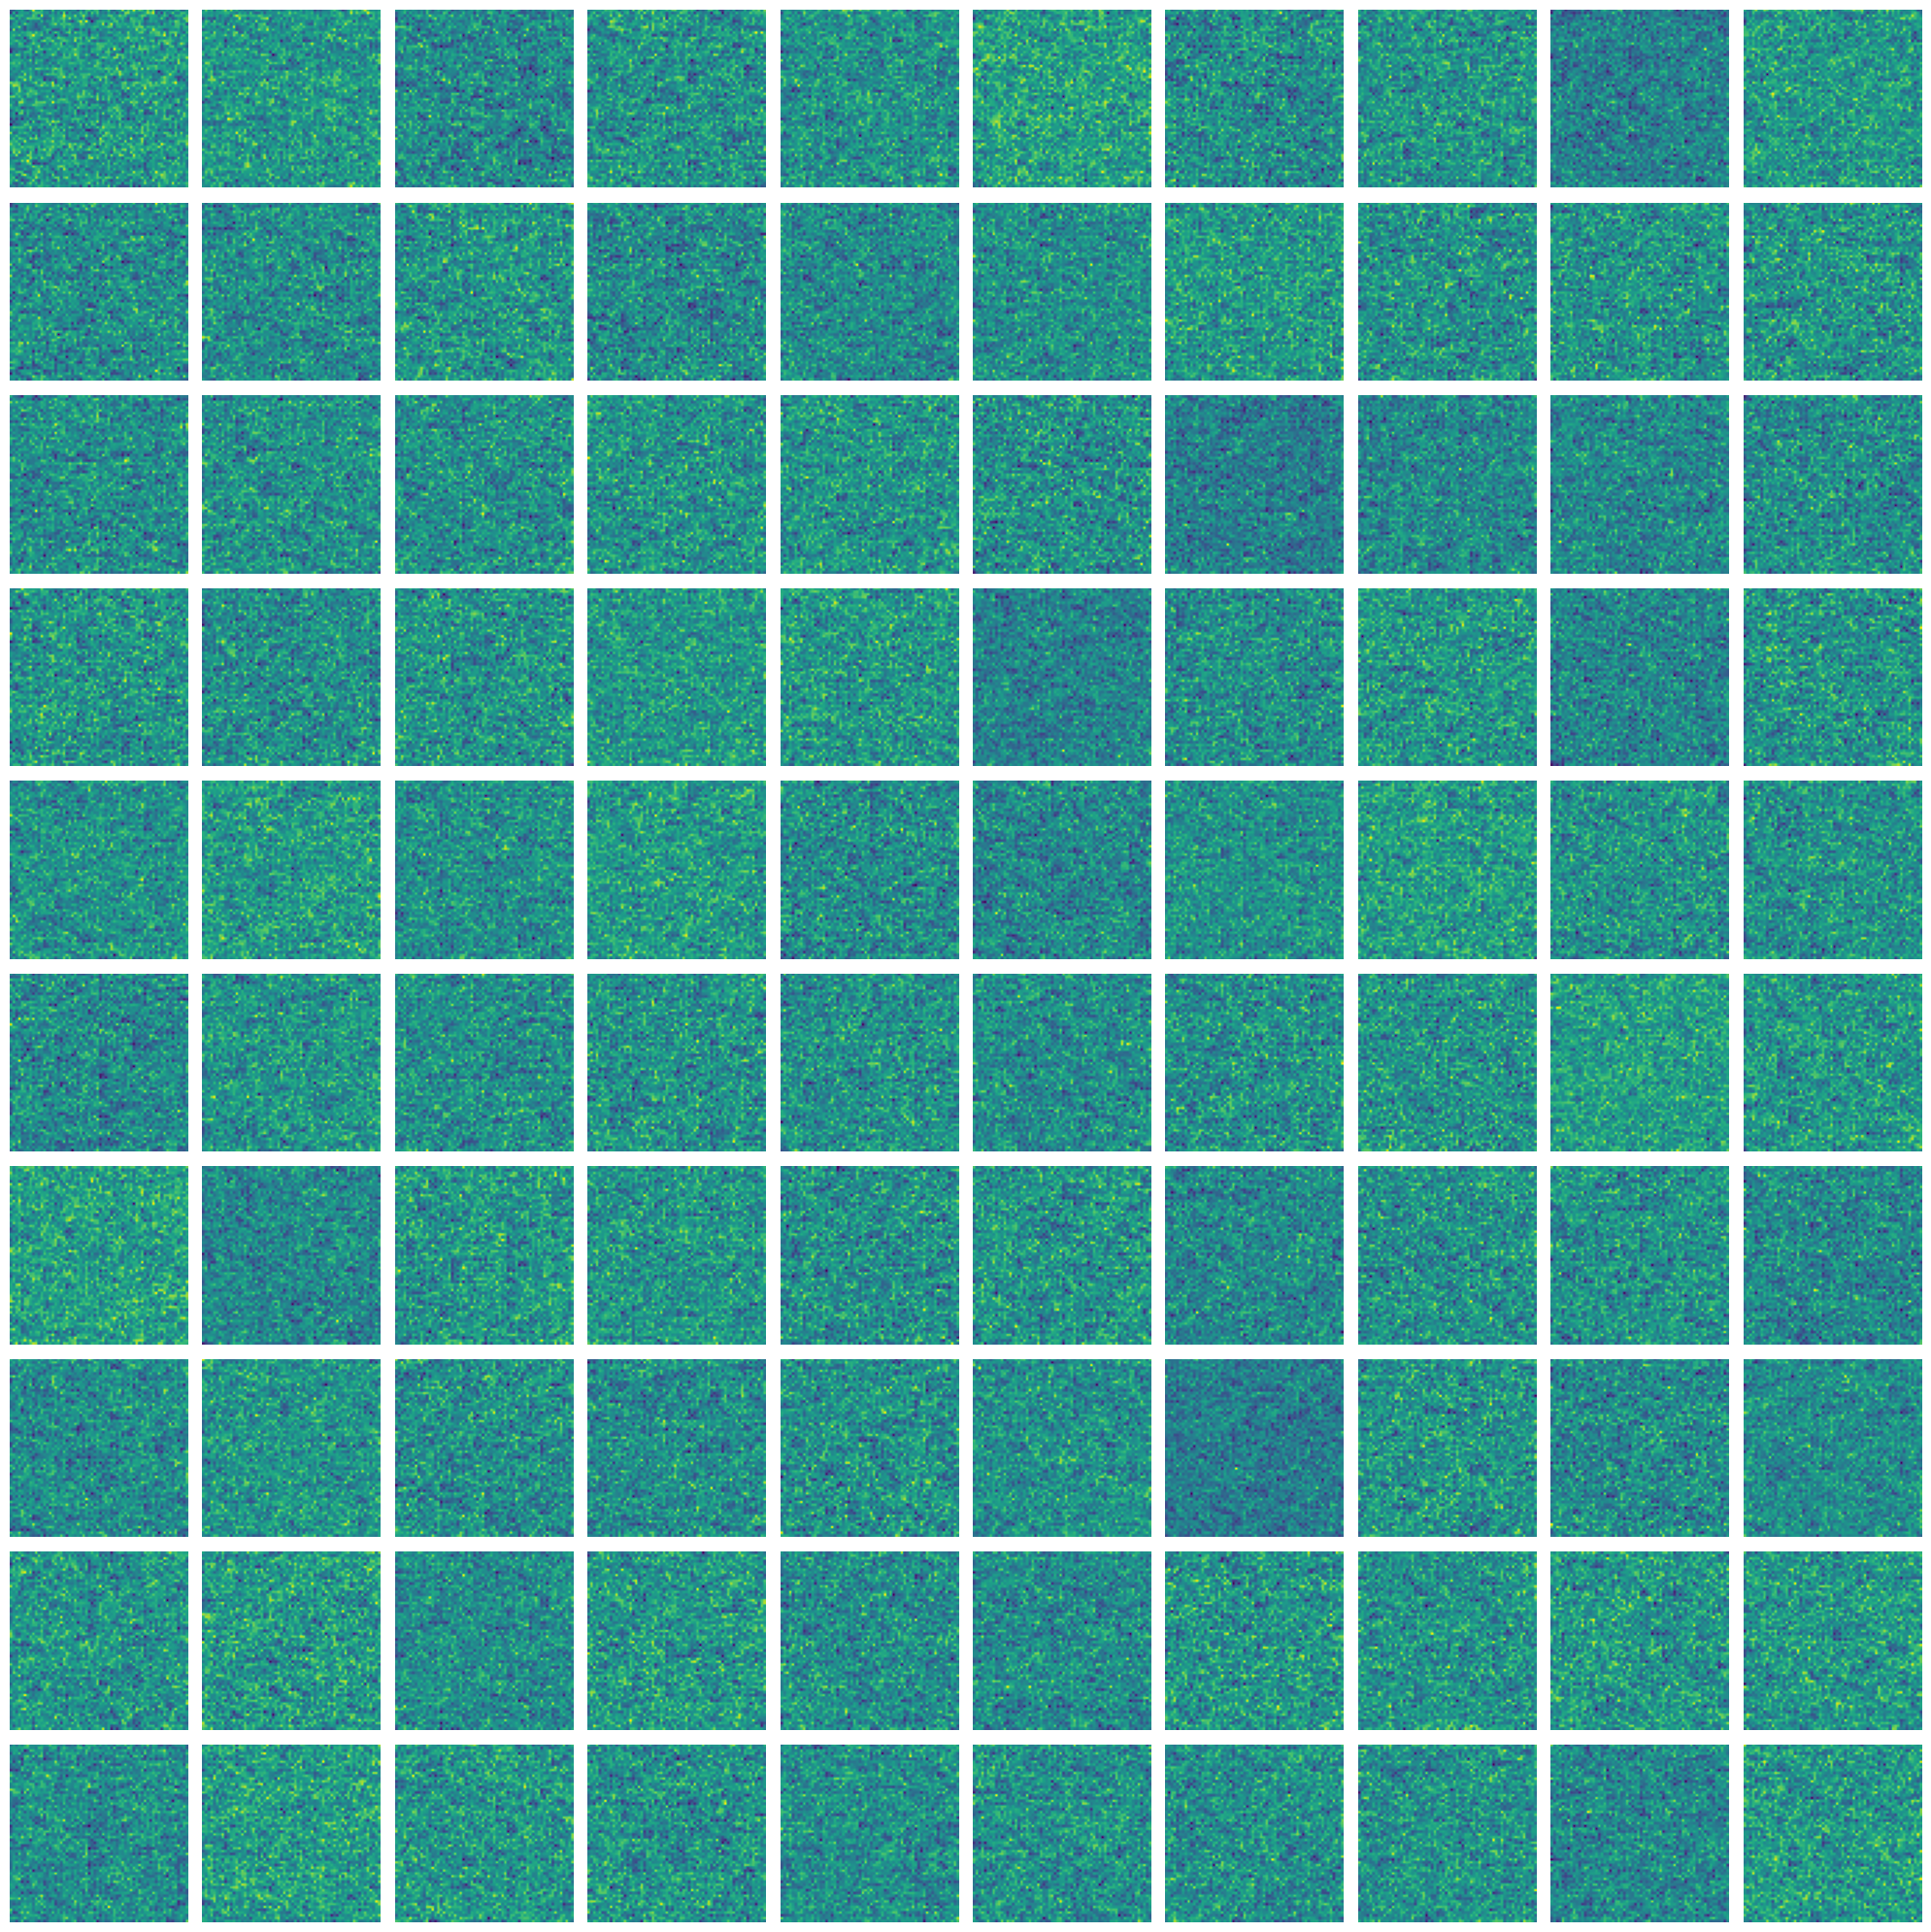

In [ ]:
def plot_mean_decoded_images(decoded_images):
    mean_image = np.mean(decoded_images, axis=0)

    plt.figure(figsize=(5, 5))
    plt.imshow(mean_image, cmap='viridis')
    plt.title("Mean of All Generated Decoded Samples")
    plt.colorbar()
    plt.show()

def plot_all_decoded_images(decoded_images, grid_size=(10, 10)):
    num_images = decoded_images.shape[0]
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))

    image_idx = 0
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if image_idx < num_images:
                axes[i, j].imshow(decoded_images[image_idx], cmap='viridis')
                axes[i, j].axis('off')
                image_idx += 1
            else:
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()
    
num_samples_to_generate = 100
new_images = generate_new_images(model, num_samples_to_generate, dim*dim*4)
plot_mean_decoded_images(new_images)
plot_all_decoded_images(new_images, grid_size=(10, 10))

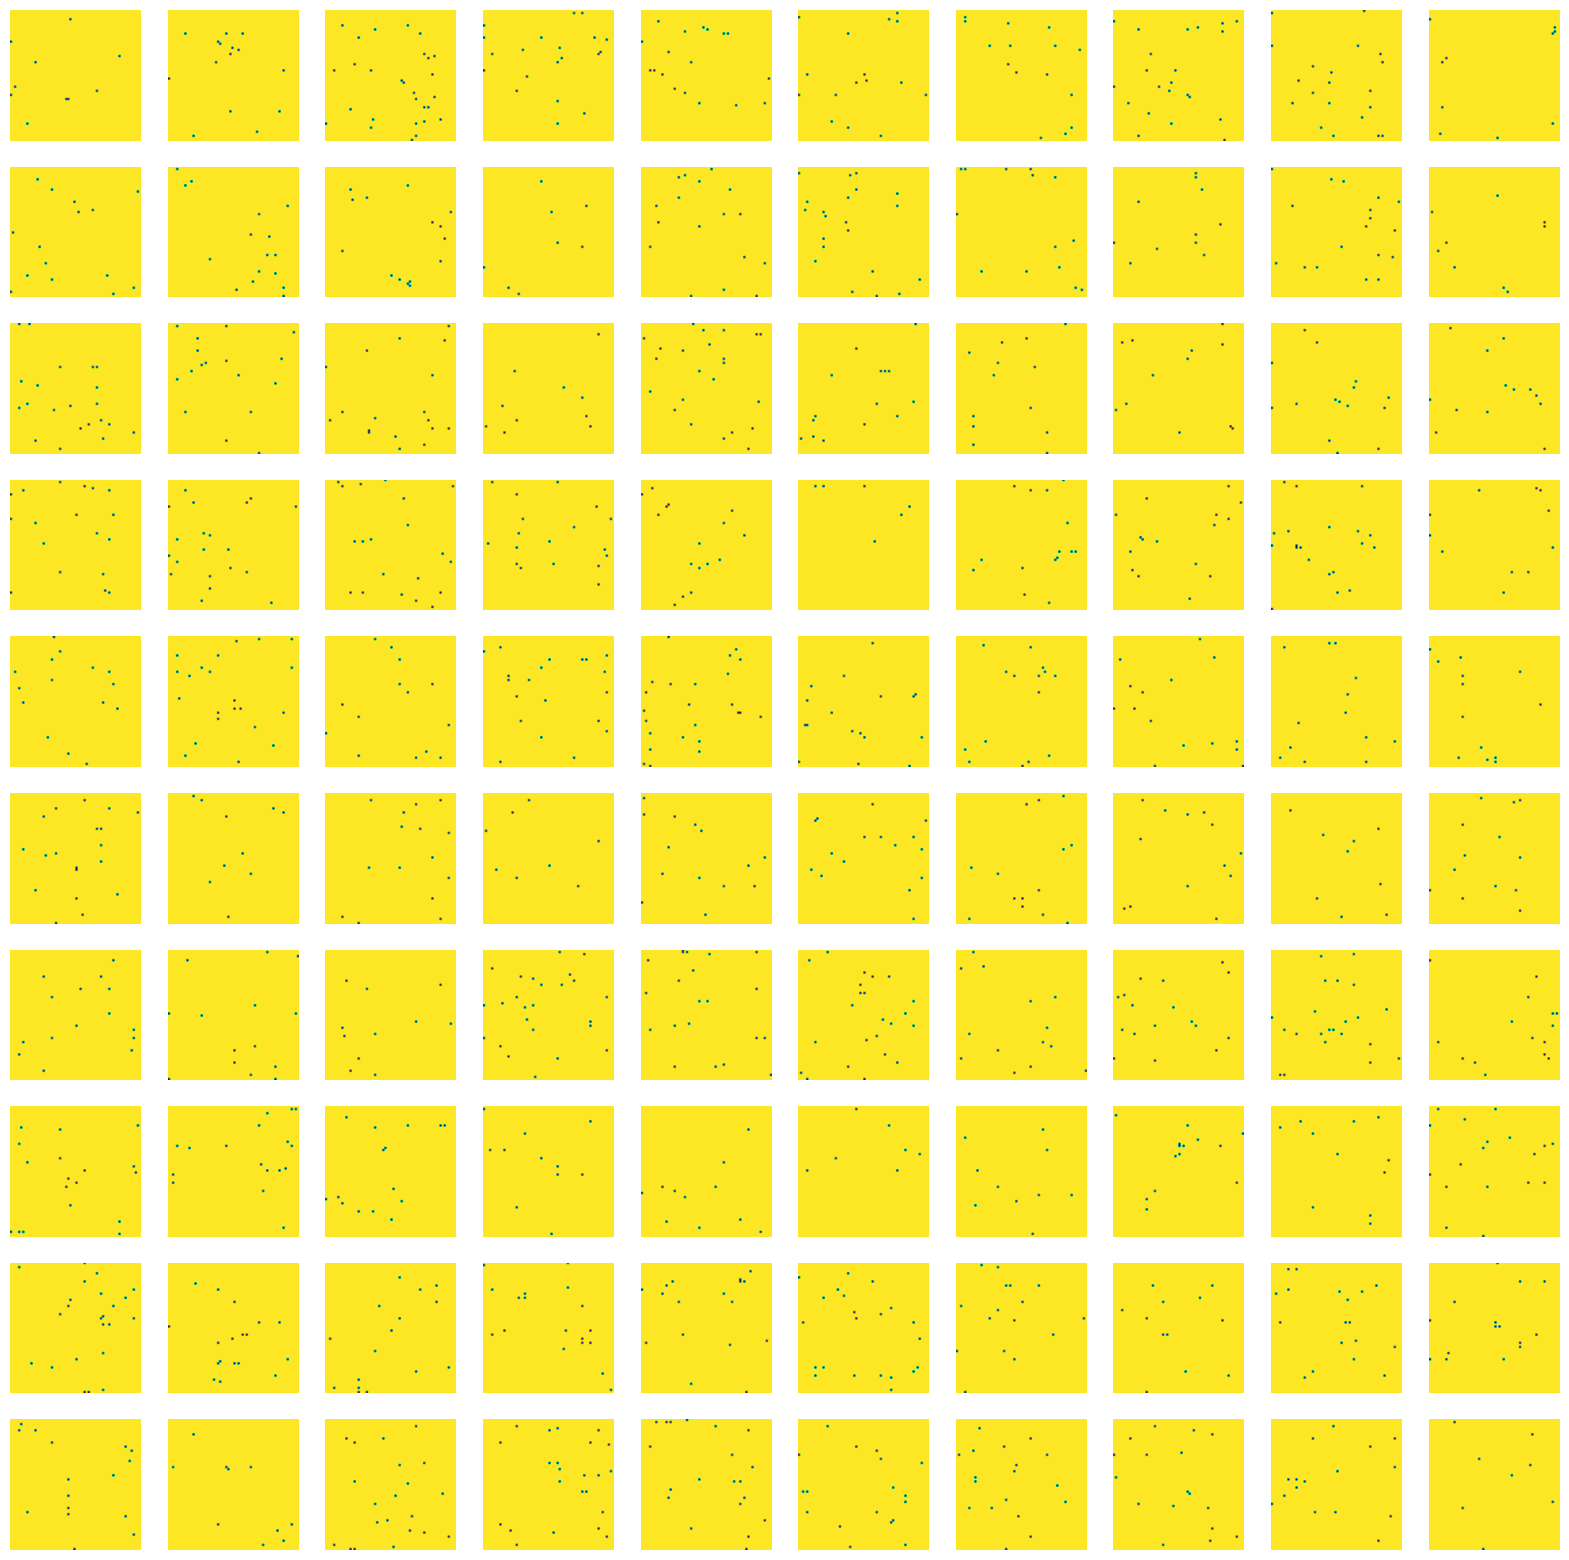

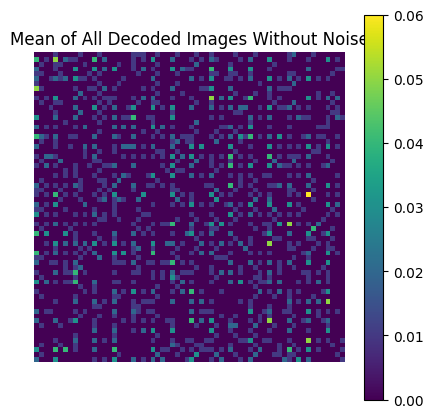

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_decoded_images_without_noise(decoded_images, grid_size=(4, 4)):
    num_images = decoded_images.shape[0]
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))

    images_without_noise = []

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if (i * grid_size[1] + j) < num_images:
                image = decoded_images[i * grid_size[1] + j]

                image_without_noise = np.where(image > .8, 1.0, 0.0)
                
                images_without_noise.append(flip(image_without_noise))
                

                axes[i, j].imshow(image_without_noise, cmap='viridis')
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')

    images_without_noise = np.array(images_without_noise)

    mean_image_without_noise = np.mean(images_without_noise, axis=0)

    plt.figure(figsize=(5, 5))
    plt.imshow(mean_image_without_noise, cmap='viridis')
    plt.title("Mean of All Decoded Images Without Noise")
    plt.colorbar()
    plt.axis('off')
    plt.show()

    plt.tight_layout()
    plt.show()

plot_decoded_images_without_noise(new_images, grid_size=(10, 10))


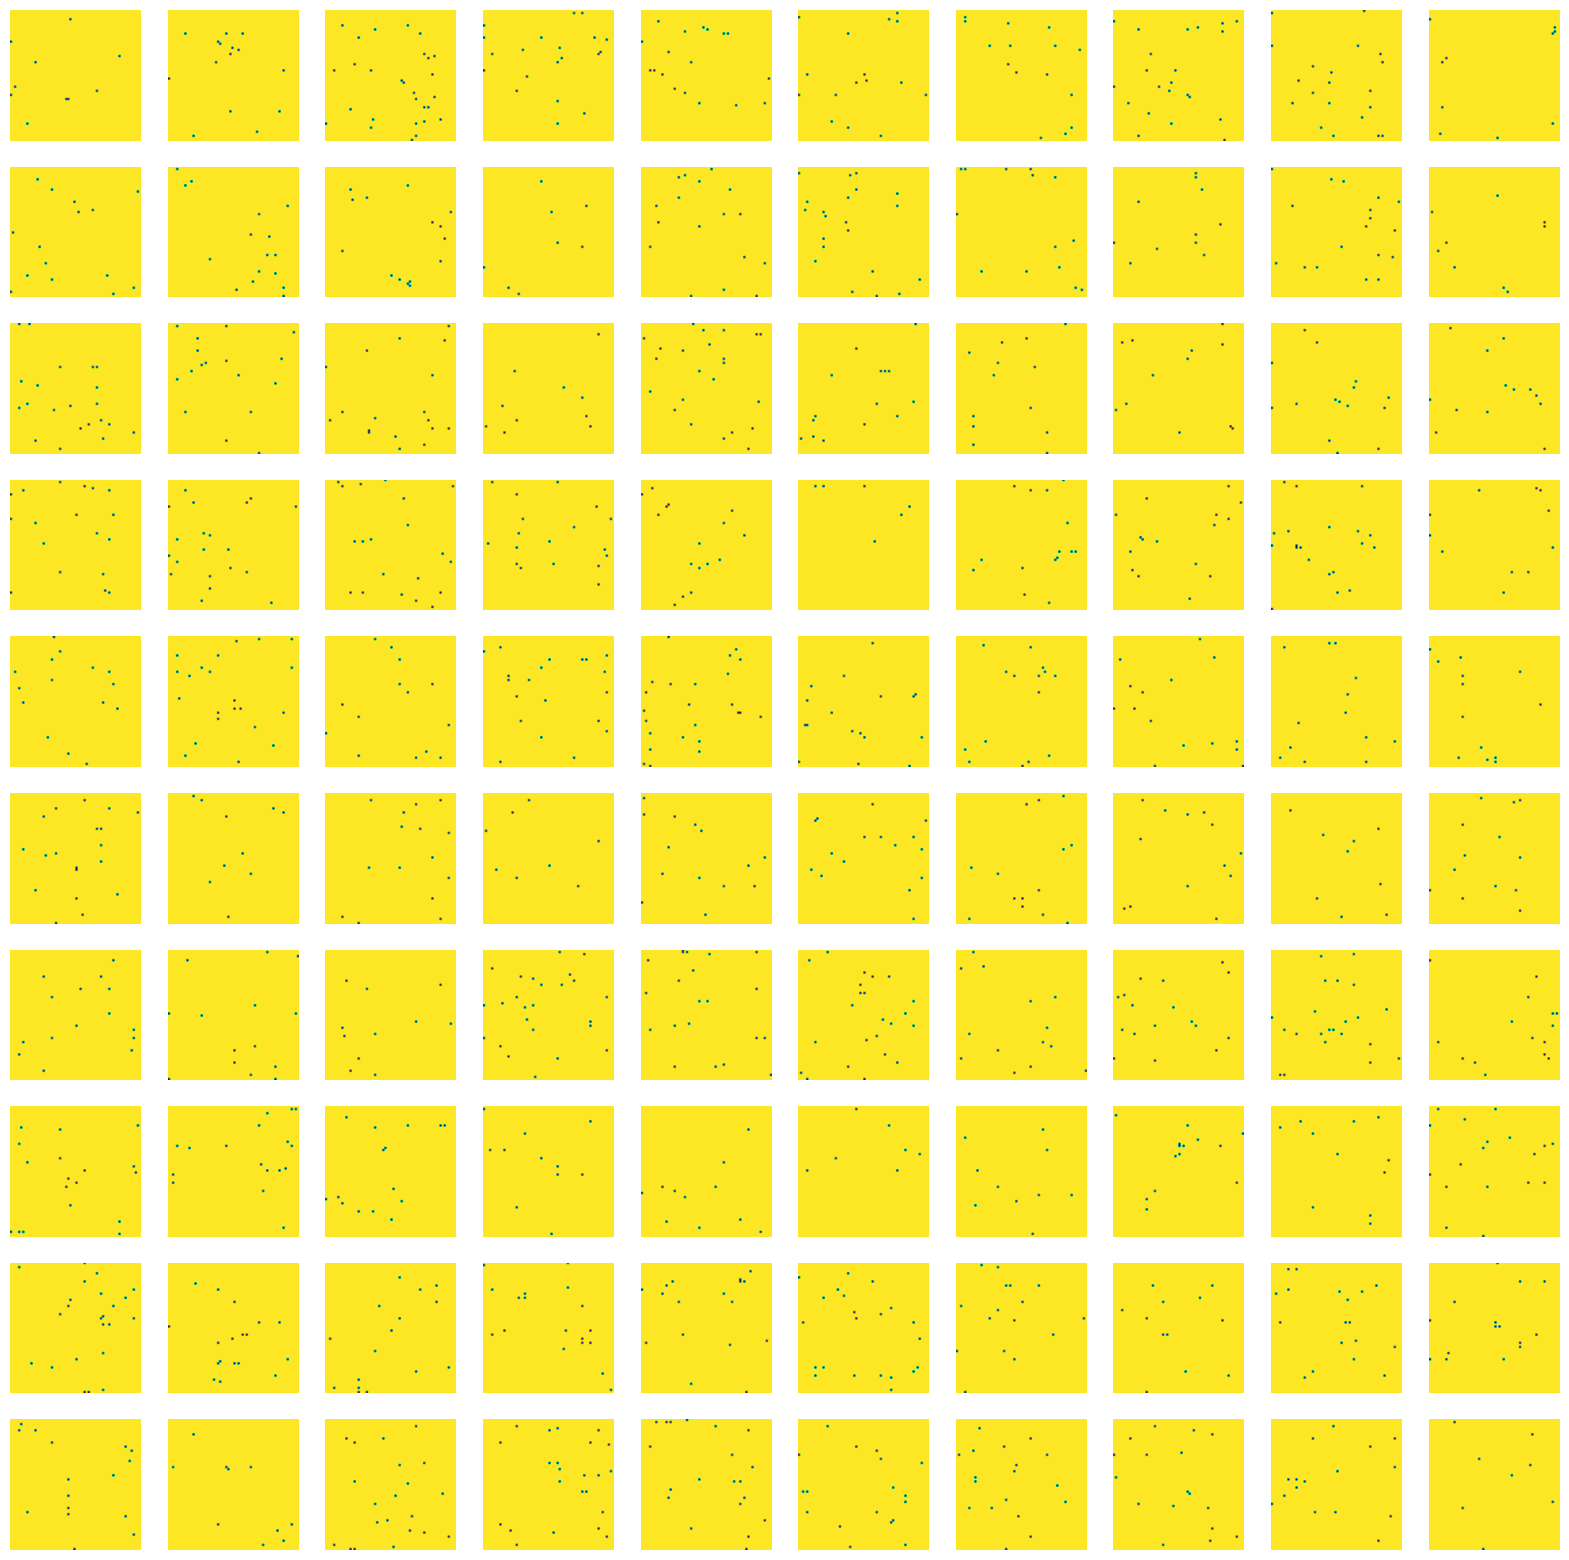

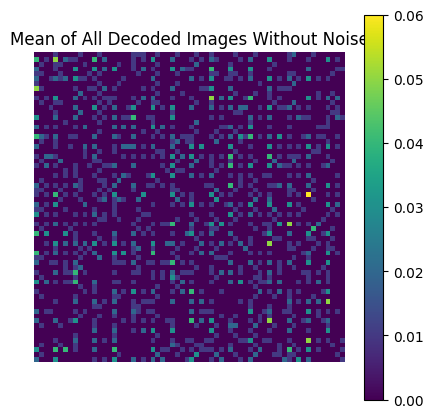

<Figure size 640x480 with 0 Axes>

TypeError: 'NoneType' object is not subscriptable

In [ ]:
denoised_images = plot_decoded_images_without_noise(new_images, grid_size=(10, 10))


limit = 10
real_data = data_X[:limit]
denoised_images = denoised_images[:limit]
mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(denoised_images)
fid = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print("FID ", fid)

mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(denoised_images)
fid = calculate_fid_stable(mu_real, sigma_real, mu_gen, sigma_gen)
print("Stable FID:", fid)

wasserstein_value = calculate_wasserstein(real_data, denoised_images)
print("Wasserstein 1 ", wasserstein_value)